In [1]:
import numpy as np, curvedsky as cs, sys, plottools as pl, local, tools_cmbalm, tqdm
from matplotlib.pyplot import *

/global/homes/t/toshiyan/Work/Lib/actlib/actsims/actsims/noise.py:9: UserWarning: No pyfftw found. Using much slower numpy fft engine.
  if 'fftw' not in pfft.engine: warnings.warn("No pyfftw found. Using much slower numpy fft engine.")


In [2]:
def aps_read(qids,Tcmb=2.72e6,**kwargs):
    aobj, mcl, ncl = {}, {}, {}
    for q in qids:
        aobj[q] = local.init_analysis_params(qid=q,**kwargs)
        mcl[q] = np.loadtxt(aobj[q].fscl['c'],unpack=True)[1] / Tcmb**2
        ncl[q] = np.loadtxt(aobj[q].fscl['n'],unpack=True)[1] / Tcmb**2
    return aobj, mcl, ncl

In [3]:
def SNR(L,ckk,nkk,Lmin=100,fsky=1600./41000.):
    snr = np.sqrt( fsky * np.sum( (L[Lmin:]+.5)*ckk[Lmin:]**2/(ckk+nkk)[Lmin:]**2 ) )
    print(snr)
    return snr

In [4]:
def comb_Nl(qids,mcl,ncl,cTT):
    Nl = 0.
    for q in qids:
        flT = (mcl[q]-ncl[q])/cTT
        Nl += flT/ncl[q]
    Nl = 1./Nl
    return Nl

In [5]:
kwargs = {'snmin':0,'snmax':10}
qids_d = ['boss_d01','boss_d02','boss_d03','boss_d04','s16_d01','s16_d02','s16_d03']
qids_n = ['boss_01','boss_02','boss_03','boss_04']
qids_t = qids_d + qids_n

In [6]:
aobj, mcl, ncl = aps_read(qids_t,**kwargs)
cTT = aobj[qids_t[0]].lcl[0,:]

In [7]:
Ncl_d = comb_Nl(qids_d,mcl,ncl,cTT)
Ncl_n = comb_Nl(qids_n,mcl,ncl,cTT)
Ncl_t = 1./(1./Ncl_d+1./Ncl_n)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
Lmax = 2048
rlmax = 3000
L = np.linspace(0,Lmax,Lmax+1)
ckk = aobj[qids_t[0]].ckk[:Lmax+1]

In [9]:
rlmins = np.arange(1000,400,-100)
SN_d = np.zeros(len(rlmins))
SN_n = np.zeros(len(rlmins))
SN_t = np.zeros(len(rlmins))
for i, rlmin in enumerate(rlmins):
    Ag = {}
    for q in tqdm.tqdm(qids_t):
        Ag[q], __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],(cTT+ncl[q])[:rlmax+1],gtype='k')
    Ag_d, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],(cTT+Ncl_d)[:rlmax+1],gtype='k')
    Ag_n, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],(cTT+Ncl_n)[:rlmax+1],gtype='k')
    Ag_t, __ = cs.norm_lens.qtt(Lmax,rlmin,rlmax,cTT[:rlmax+1],(cTT+Ncl_t)[:rlmax+1],gtype='k')
    #Ag['TE'], Ac['TE'] = cs.norm_lens.qte(Lmax,rlmin,rlmax,lcl[3,:],lcl[0,:],lcl[1,:])
    #Ag['EE'], Ac['EE'] = cs.norm_lens.qee(Lmax,rlmin,rlmax,lcl[1,:],lcl[1,:])
    #Ag['TB'], Ac['TB'] = cs.norm_lens.qtb(Lmax,rlmin,rlmax,lcl[3,:],lcl[0,:],lcl[2,:])
    #Ag['EB'], Ac['EB'] = cs.norm_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],lcl[1,:],lcl[2,:])
    SN_d[i] = SNR(L,ckk,Ag_d)
    SN_n[i] = SNR(L,ckk,Ag_n)
    SN_t[i] = SNR(L,ckk,Ag_t)

  9%|▉         | 1/11 [00:02<00:25,  2.50s/it]

18.46464274899292
14.972645268124772
22.601070177871712


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

18.7581339176748
15.257781524022311
22.910125852634167


  0%|          | 0/11 [00:00<?, ?it/s]

19.316220703140498
15.83524690230945
23.458695095772374


  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

19.599105926031985
16.116344152232497
23.752505444077247


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

19.72032506887171
16.234474609554265
23.885991364120933


100%|██████████| 11/11 [00:28<00:00,  2.57s/it]


19.832724342292778
16.34773614328183
24.008213151078532


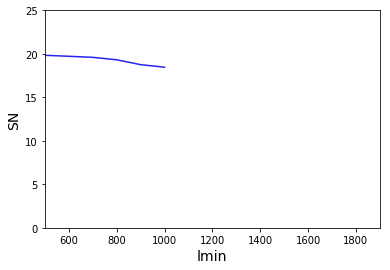

In [10]:
pl.plot_1dstyle(xmin=500,xmax=1900,ymin=0,ymax=25,xlab='lmin',ylab='SN')
plot(rlmins,SN_d)

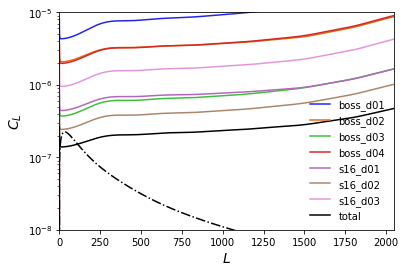

In [11]:
pl.plot_1dstyle(ylog=True,xmin=1,xmax=Lmax,ymin=1e-8,ymax=1e-5)
for q in qids_d:
    plot(L,Ag[q],label=q)
plot(L,Ag_d,'-',label='total',color='k')
plot(L,ckk,color='k',ls='-.')
legend()

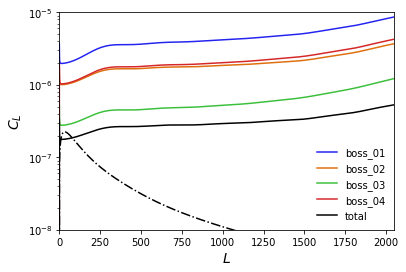

In [12]:
pl.plot_1dstyle(ylog=True,xmin=1,xmax=Lmax,ymin=1e-8,ymax=1e-5)
for q in qids_n:
    plot(L,Ag[q],label=q)
plot(L,Ag_n,'-',label='total',color='k')
plot(L,ckk,color='k',ls='-.')
legend()

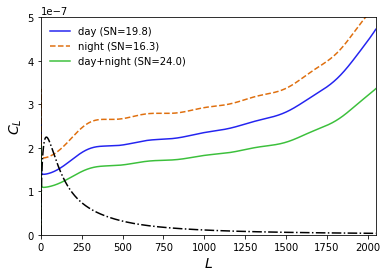

In [14]:
pl.plot_1dstyle(ylog=False,xmin=1,xmax=Lmax,ymin=0.,ymax=5e-7)
plot(L,Ag_d,'-',label='day (SN='+str(np.round(SN_d[-1],1))+')')
plot(L,Ag_n,'--',label='night (SN='+str(np.round(SN_n[-1],1))+')')
plot(L,Ag_t,'-',label='day+night (SN='+str(np.round(SN_t[-1],1))+')')
plot(L,ckk,color='k',ls='-.')
legend()